In [ ]:
!pip install lmfit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from datetime import timedelta, datetime
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit

In [ ]:
#importing global data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_global = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths_global = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recovered_global = pd.read_csv(url, error_bad_lines=False)

In [ ]:
#extract data for Tunisia 
index_tn = 212 # Tunisia's index in the dataset
start = 4 #remove the region columns to start from the first date in the dataset
confirmed = confirmed_global.iloc[index_tn,start:]
deaths = deaths_global.iloc[index_tn,start:]
recovered = recovered_global.iloc[index_tn,start:]
tn = {'confirmed': confirmed, 'deaths': deaths,'recovered': recovered}
tn = pd.DataFrame(tn)
tn =tn[tn.confirmed != 0] # removing dates where there are no confirmed cases: dataset starts with the first confirmed case
tn.tail()

,confirmed,deaths,recovered
4/29/20,980,40,294
4/30/20,994,41,305
5/1/20,998,41,316
5/2/20,1009,42,323
5/3/20,1013,42,328


In [ ]:
Tunisia = tn.reset_index().rename(columns={'index': 'date'})
#Tunisia['date'] = pd.to_datetime(Tunisia['date'])
Tunisia.head()

,date,confirmed,deaths,recovered
0,3/4/20,1,0,0
1,3/5/20,1,0,0
2,3/6/20,1,0,0
3,3/7/20,1,0,0
4,3/8/20,2,0,0


In [ ]:
N = 11818619	
#N = sum(gov.iloc[:,2])

In [ ]:
def f(y, t, paras):
    """
    Your system of differential equations
    """

    S = y[0]
    I = y[1]
    R = y[2]

    try:
        beta = paras['beta'].value
        gamma = paras['gamma'].value

    except KeyError:
        beta, gamma = paras
    # the model equations
    dS = -beta/N * I * S
    dI = beta/N * I * S - gamma * I
    dR = gamma * I
    return [dS,dI,dR]


In [ ]:
def g(t, SIR0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    SIR = odeint(f, SIR0, t, args=(paras,))
    return SIR


In [ ]:
def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    SIR0 = paras['S0'].value, paras['I0'].value, paras['R0'].value
    model = g(t, SIR0, paras)

    # you only have data for one of your variables
    x2_model = model[:, 1]
    return (x2_model - data).ravel()

In [ ]:
# measured data
infected = Tunisia.iloc[:,1]
infected = infected.to_numpy()
infected = np.array(infected,dtype='float64')
t_measured = list(range(len(infected)))
#t_measured = np.array(t_measured, dtype='float64')

In [ ]:
# initial conditions
S0= N-infected[0]
I0 = infected[0]
R0 = 0
y0 = [S0, I0, R0]

In [ ]:
# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('S0', value=S0, vary=False)
params.add('I0', value=I0, vary=False)
params.add('R0', value=R0, vary=False)
params.add('beta', value=0.1, min=0.0001, max=0.5)
params.add('gamma', value=0.3, min=0.0001, max=1)

In [ ]:
# fit model
result = minimize(residual, params, args=(t_measured, infected), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(list(range(len(infected))), y0, result.params)

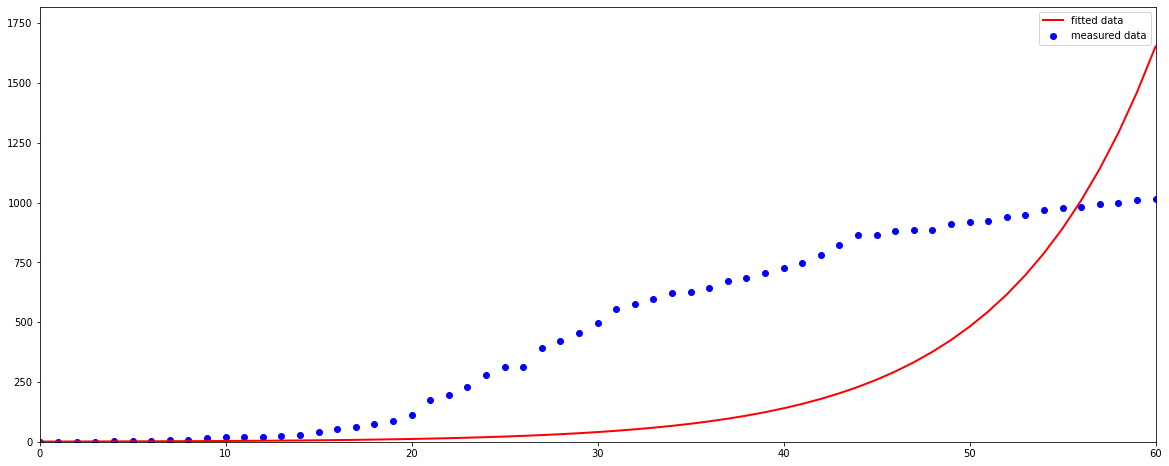

In [ ]:
# plot fitted data
fig = plt.figure(figsize=(20,8))
plt.plot(list(range(len(infected))), data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.scatter(list(range(len(infected))),infected, marker='o', color='b', label='measured data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])

plt.show()

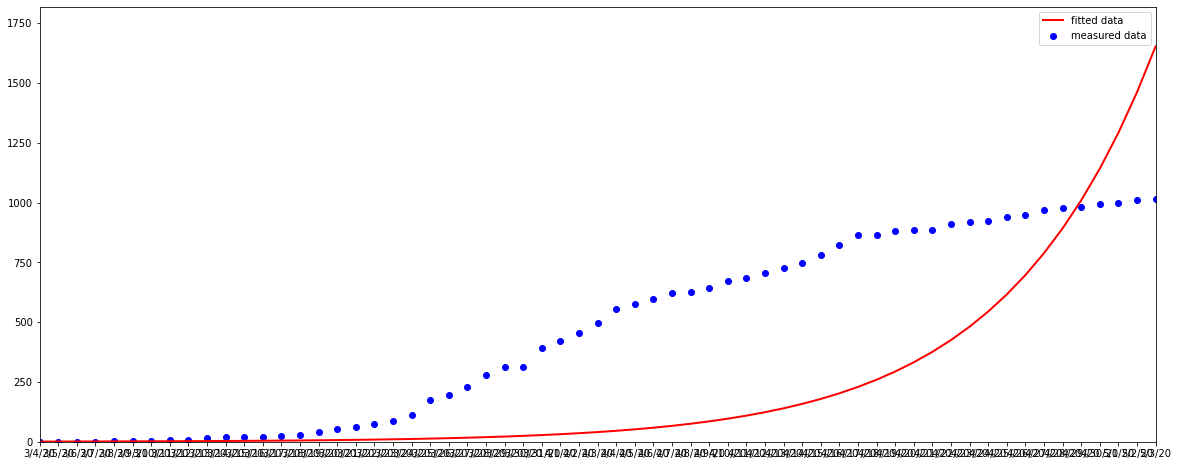

In [ ]:
# plot fitted data
fig = plt.figure(figsize=(20,8))
plt.plot(Tunisia.date, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.scatter(list(range(len(infected))),infected, marker='o', color='b', label='measured data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])

plt.show()

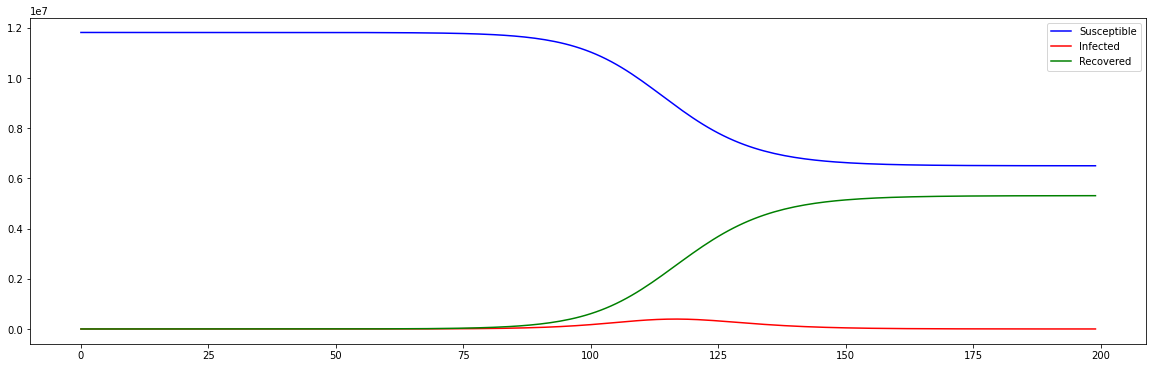

In [ ]:
t = list(range(200))
preds = g(t, y0, result.params)
#plot predictions of the model

fig = plt.figure(figsize=(20,6))
plt.plot(preds[:, 0],"b-")
plt.plot(preds[:, 1],"r-")
plt.plot(preds[:, 2],"g-")
plt.legend(["Susceptible","Infected","Recovered"])

In [ ]:
max_I1 = max(preds[:, 1])
day_max1 = np.argmax(preds[:, 1])
day_max1

117

In [ ]:
max_I7 = max(preds[:, 1])
day_max7 = np.argmax(preds[:, 1])
print(max_I7)
print(day_max7)

394594.73001629906
117


In [ ]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
S0,11818618.0,0.00000000,(0.00%),11818618.0,-inf,inf,False
I0,1.00000000,0.00000000,(0.00%),1.0,-inf,inf,False
R0,0.00000000,0.00000000,,0,-inf,inf,False
beta,0.49999995,27.2374228,(5447.49%),0.1,1.0000e-04,0.50000000,True
gamma,0.37646477,57.5185292,(15278.60%),0.3,1.0000e-04,1.00000000,True


In [ ]:
gov = pd.read_excel (r'/content/drive/My Drive/gov.xlsx', sheet_name='04-04')

In [ ]:
totcases = sum(gov.iloc[:,1])

pop = gov.iloc[:,2].to_numpy()
cases = gov.iloc[:,1].to_numpy()

N = 0
for i in range(len(pop)):
    N = N + cases[i] * pop[i] / totcases

In [ ]:
# initial conditions
S0= N-infected[0]
I0 = infected[0]
R0 = 0
y0 = [S0, I0, R0]
# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('S0', value=S0, vary=False)
params.add('I0', value=I0, vary=False)
params.add('R0', value=R0, vary=False)
params.add('beta', value=0.1, min=0.0001, max=0.5)
params.add('gamma', value=0.3, min=0.0001, max=1)

In [ ]:
# fit model
result = minimize(residual, params, args=(t_measured, infected), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(list(range(len(infected))), y0, result.params)

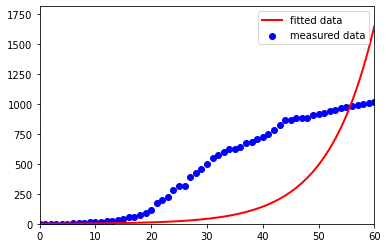

In [ ]:
# plot fitted data
plt.plot(list(range(len(infected))), data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.scatter(list(range(len(infected))),infected, marker='o', color='b', label='measured data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])

plt.show()

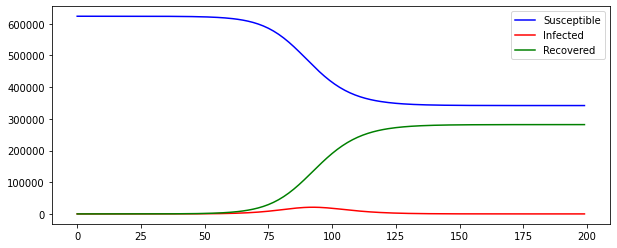

In [ ]:
t = list(range(200))
preds = g(t, y0, result.params)
#plot predictions of the model

fig = plt.figure(figsize=(10,4))
plt.plot(preds[:, 0],"b-")
plt.plot(preds[:, 1],"r-")
plt.plot(preds[:, 2],"g-")
plt.legend(["Susceptible","Infected","Recovered"])

In [ ]:
max_I2 = max(preds[:, 1])
day_max2 = np.argmax(preds[:, 1])

In [ ]:
regions = ["Nord est", "Nord ouest","Centre est","Centre ouest","Sud est","Sud ouest"]
reggov = [[1,2,8,11,15,16,17],[18,21,22,24],[7,10,12,13],[5,20,23],[3,9,14],[4,6,19]]

for i in range(len(reggov)):
    for j in range(len(reggov[i])):
        reggov[i][j] = reggov[i][j] -1

totcases = sum(gov.iloc[:,1])

pop = gov.iloc[:,2].to_numpy()
cases = gov.iloc[:,1].to_numpy()

pop1 = [0] * 6
cases1 = [0] * 6
for i in range(6):
    pop1[i] = 0 
    cases1[i] = 0
    for j in reggov[i]:
        pop1[i] = pop1[i] + pop[j]
        cases1[i] = cases1[i] + cases[j]


N = 0
for i in range(len(pop1)):
    N = N + cases1[i] * pop1[i] / totcases
N

2951430.206060606

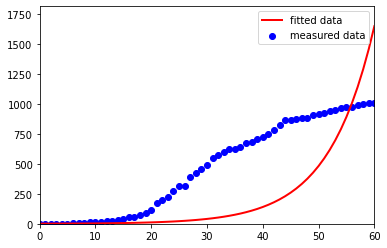

In [ ]:
# initial conditions
S0= N-infected[0]
I0 = infected[0]
R0 = 0
y0 = [S0, I0, R0]

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('S0', value=S0, vary=False)
params.add('I0', value=I0, vary=False)
params.add('R0', value=R0, vary=False)
params.add('beta', value=0.1, min=0.0001, max=0.5)
params.add('gamma', value=0.3, min=0.0001, max=1)

# fit model
result = minimize(residual, params, args=(t_measured, infected), method='leastsq')  # leastsq nelder

# check results of the fit
data_fitted = g(list(range(len(infected))), y0, result.params)

# plot fitted data
plt.plot(list(range(len(infected))), data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.scatter(list(range(len(infected))),infected, marker='o', color='b', label='measured data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])

plt.show()

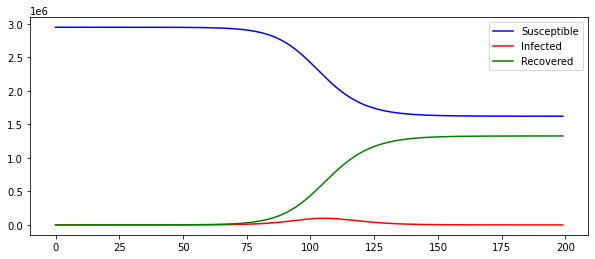

In [ ]:
t = list(range(200))
preds = g(t, y0, result.params)
#plot predictions of the model

fig = plt.figure(figsize=(10,4))
plt.plot(preds[:, 0],"b-")
plt.plot(preds[:, 1],"r-")
plt.plot(preds[:, 2],"g-")
plt.legend(["Susceptible","Infected","Recovered"])

In [ ]:
max_I3 = max(preds[:, 1])
day_max3 = np.argmax(preds[:, 1])

In [ ]:
gamma = 1/10

In [ ]:
totcases = sum(gov.iloc[:,1])

pop = gov.iloc[:,2].to_numpy()
cases = gov.iloc[:,1].to_numpy()

N = 0
for i in range(len(pop)):
    N = N + cases[i] * pop[i] / totcases

In [ ]:
def f(y, t, paras):
    """
    Your system of differential equations
    """

    S = y[0]
    I = y[1]
    R = y[2]

    try:
        beta = paras['beta'].value

    except KeyError:
        beta = paras
    # the model equations
    dS = -beta/N * I * S
    dI = beta/N * I * S - gamma * I
    dR = gamma * I
    return [dS,dI,dR]

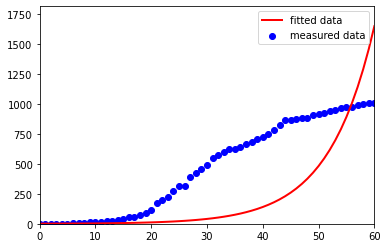

In [ ]:
# initial conditions
S0= N-infected[0]
I0 = infected[0]
R0 = 0
y0 = [S0, I0, R0]

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('S0', value=S0, vary=False)
params.add('I0', value=I0, vary=False)
params.add('R0', value=R0, vary=False)
params.add('beta', value=0.1, min=0.0001, max=0.5)

# fit model
result = minimize(residual, params, args=(t_measured, infected), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(list(range(len(infected))), y0, result.params)

# plot fitted data
plt.plot(list(range(len(infected))), data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.scatter(list(range(len(infected))),infected, marker='o', color='b', label='measured data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])

plt.show()

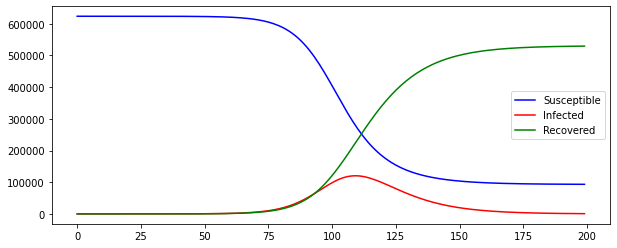

In [ ]:
t = list(range(200))
preds = g(t, y0, result.params)
#plot predictions of the model

fig = plt.figure(figsize=(10,4))
plt.plot(preds[:, 0],"b-")
plt.plot(preds[:, 1],"r-")
plt.plot(preds[:, 2],"g-")
plt.legend(["Susceptible","Infected","Recovered"])

In [ ]:
max_I4 = max(preds[:, 1])
day_max4 = np.argmax(preds[:, 1])

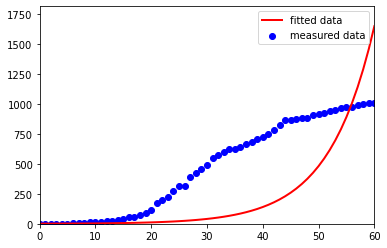

In [ ]:
gamma = 1/15

# initial conditions
S0= N-infected[0]
I0 = infected[0]
R0 = 0
y0 = [S0, I0, R0]

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('S0', value=S0, vary=False)
params.add('I0', value=I0, vary=False)
params.add('R0', value=R0, vary=False)
params.add('beta', value=0.1, min=0.0001, max=0.5)

# fit model
result = minimize(residual, params, args=(t_measured, infected), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(list(range(len(infected))), y0, result.params)

# plot fitted data
plt.plot(list(range(len(infected))), data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.scatter(list(range(len(infected))),infected, marker='o', color='b', label='measured data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])

plt.show()

In [ ]:
t = list(range(200))
preds = g(t, y0, result.params)
#plot predictions of the model

fig = plt.figure(figsize=(10,4))
plt.plot(preds[:, 0],"b-")
plt.plot(preds[:, 1],"r-")
plt.plot(preds[:, 2],"g-")
plt.legend(["Susceptible","Infected","Recovered"])

In [ ]:
max_I5 = max(preds[:, 1])
day_max5 = np.argmax(preds[:, 1])

In [ ]:

def f(y, t, paras):
    """
    Your system of differential equations
    """

    S = y[0]
    I = y[1]
    R = y[2]

    try:
        beta = paras['beta'].value
        gamma = paras['gamma'].value

    except KeyError:
        beta, gamma = paras
    # the model equations
    dS = -beta/N * I * S
    dI = beta/N * I * S - gamma * I
    dR = gamma * I
    return [dS,dI,dR]


def g(t, SIR0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    SIR = odeint(f, SIR0, t, args=(paras,))
    return SIR


def residual(paras, t, data_inf, data_rem):

    """
    compute the residual between actual data and fitted data
    """

    SIR0 = paras['S0'].value, paras['I0'].value, paras['R0'].value
    model = g(t, SIR0, paras)

    # you only have data for one of your variables
    x2_model = model[:, 1]
    x3_model = model[:, 2]
    return ((x2_model - data_inf)+(x3_model-data_rem)).ravel()


In [ ]:
totcases = sum(gov.iloc[:,1])

pop = gov.iloc[:,2].to_numpy()
cases = gov.iloc[:,1].to_numpy()

N = 0
for i in range(len(pop)):
    N = N + cases[i] * pop[i] / totcases

#N = sum(gov.iloc[:,2])
    
# measured data
infected = Tunisia.iloc[:,1]
infected = infected.to_numpy()
infected = np.array(infected,dtype='float64')
t_measured = list(range(len(infected)))

removed = Tunisia.iloc[:,2] - infected
removed = removed.to_numpy()

# initial conditions
S0= N-infected[0]
I0 = infected[0]
R0 = 0
y0 = [S0, I0, R0]


# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('S0', value=S0, vary=False)
params.add('I0', value=I0, vary=False)
params.add('R0', value=R0, vary=False)
params.add('beta', value=0.5, min=0.0001, max=1)
params.add('gamma', value=0.05, min=0.005, max=0.1)

In [ ]:
# fit model
result = minimize(residual, params, args=(t_measured, infected, removed), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(list(range(len(infected))), y0, result.params)

TypeError: ignored

error: ignored

In [ ]:
# plot fitted data
plt.plot(list(range(len(infected))), data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data infected')
plt.scatter(list(range(len(infected))),infected, marker='o', color='b', label='measured data infected')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])

plt.show()